In [1]:
%matplotlib inline
import os, time, random, math
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from IPython.core.display import Image, display
from sklearn import preprocessing
from torch.distributions import normal
from tqdm import tnrange, tqdm_notebook

In [24]:
import kornia

In [25]:
c = 3 # make 3 for color

In [26]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128, vector_size=100):
        super(generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        self.deconv1_2 = nn.ConvTranspose2d(vector_size+1, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, c, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = self.deconv1_1(input)        
        x = self.deconv1_1_bn(x)
        x = F.relu(x)
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = self.deconv4(x)
        x = torch.tanh(x)
        return x


class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128, vector_size=100):
        super(discriminator, self).__init__()
        self.d = d
        self.conv1_1 = nn.Conv2d(c, int(d/2), 4, 2, 1)
        self.conv2 = nn.Conv2d(int(d/2), d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.fc1 = nn.Linear(d*4*4*4, 512)
        
        # Vector size + 1 because the first dimension is for real / fake.
        self.fc2 = nn.Linear(512, vector_size+1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, noise_mult=6):
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)

        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)

        x = x.view(self.d, self.d*4*4*4)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
#         x = torch.tanh(x)
        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [27]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))
    y1 = hist['D_losses']
    y2 = hist['G_losses']
    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc=1)
    plt.grid(True)
    plt.tight_layout()
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()

In [34]:
class TVLoss(nn.Module):
    def __init__(self,TVLoss_weight=1):
        super(TVLoss,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self._tensor_size(x[:,:,1:,:])
        count_w = self._tensor_size(x[:,:,:,1:])
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size

    def _tensor_size(self,t):
        return t.size()[1]*t.size()[2]*t.size()[3]

In [35]:
def make_images(G, z, x):
    test_images = G(z, x)
    test_images = (test_images.cpu() + 1) * 0.5
    test_images = test_images.data.view(test_images.shape[0], c, 32, 32)
    return test_images

def show_images(images, path='result.png', rows=8):
    save_image(images, path, nrow=rows, padding=1, pad_value=1.0, scale_each=False, normalize=False)
    display(Image(path))

In [38]:
def make_data(batch_size, vector_size, onehot=True):
    x = torch.zeros(batch_size, vector_size+1, 1, 1)
    y = torch.zeros(batch_size)
        
    if onehot:
        for i in range(batch_size):
            # Dont use zero index which is for fake data.
            v = random.randint(1, vector_size)
            x[i, v] = 1.0
            y[i] = v
        #, y.type(torch.LongTensor).cuda()
    else:
        x = torch.zeros(batch_size, vector_size+1, 1, 1)
        y = torch.zeros(batch_size)
        for i in range(batch_size):
            for _ in range(10):
                # Dont use zero index which is for fake data.
                v = random.randint(1, vector_size)
                x[i, v] = 1.0
                y[i] = v
    return x.cuda(), y.type(torch.LongTensor).cuda()

In [39]:
# images_1 = make_images(G, fixed_z, fixed_x)
# images_2 = make_images(G, fixed_z, fixed_x2)
# show_images(torch.cat((images_1, images_2), 0), rows=16)

training start!
Starting 0


[1/16] - ptime: 117.94, loss_d: 3.49953651, loss_g: 3.48781371


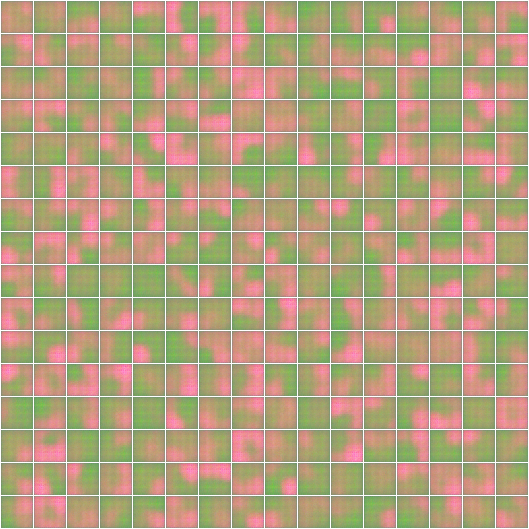

Starting 1


[2/16] - ptime: 118.45, loss_d: 0.24150805, loss_g: 0.27165097


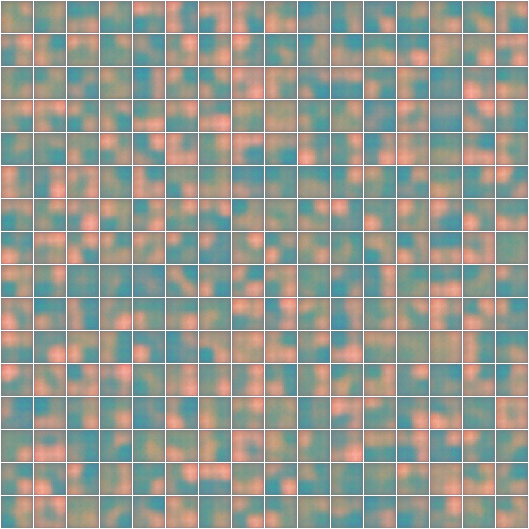

Starting 2


[3/16] - ptime: 119.27, loss_d: 0.02056488, loss_g: 0.03858907


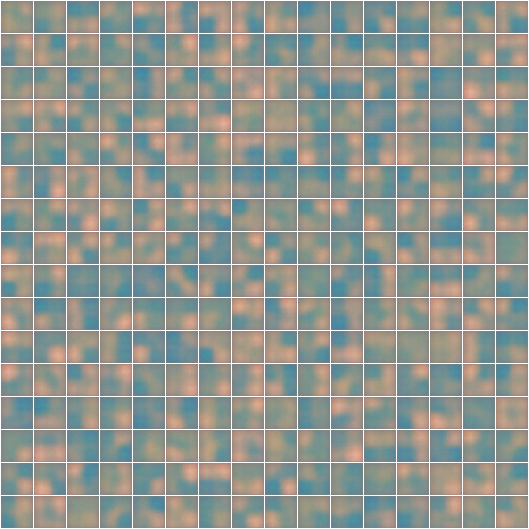

Starting 3


[4/16] - ptime: 118.87, loss_d: 0.26729926, loss_g: 0.34740084


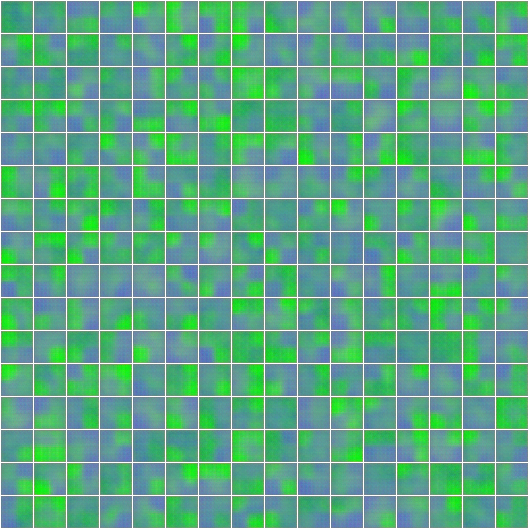

Starting 4


[5/16] - ptime: 119.05, loss_d: 0.02634057, loss_g: 0.05016467


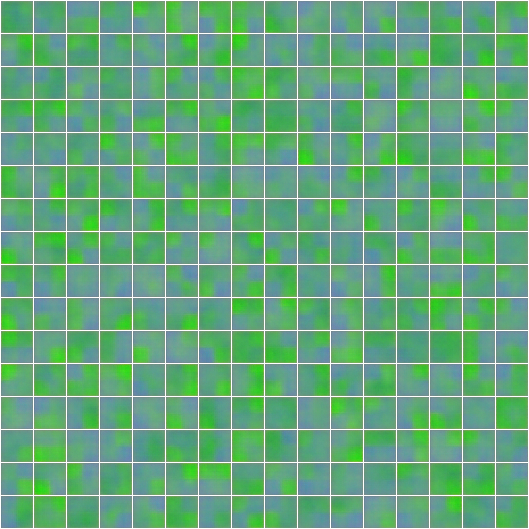

Starting 5


[6/16] - ptime: 118.79, loss_d: 0.00544460, loss_g: 0.02047516


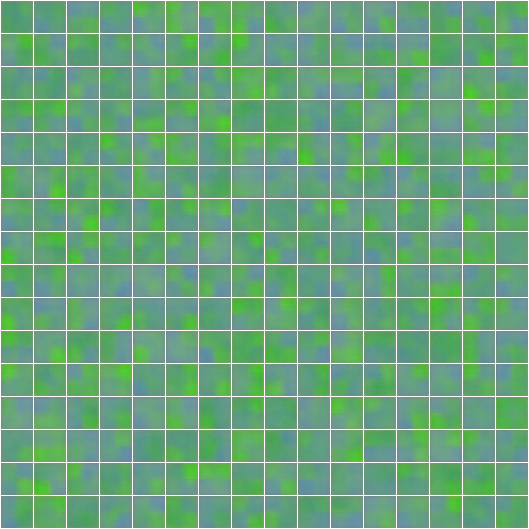

Starting 6


[7/16] - ptime: 118.89, loss_d: 0.07783692, loss_g: 0.13141331


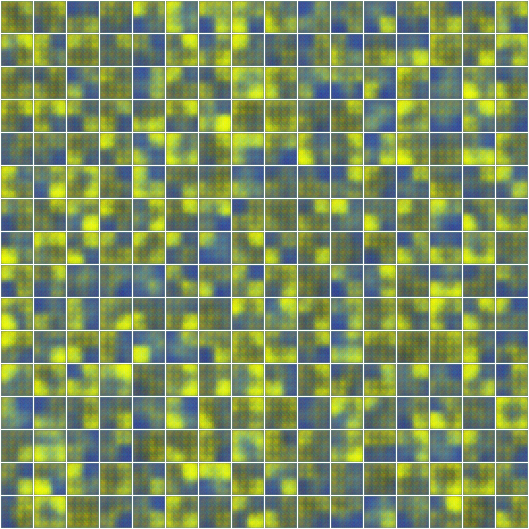

Starting 7
learning rate change!


[8/16] - ptime: 118.97, loss_d: 0.20248351, loss_g: 0.23069115


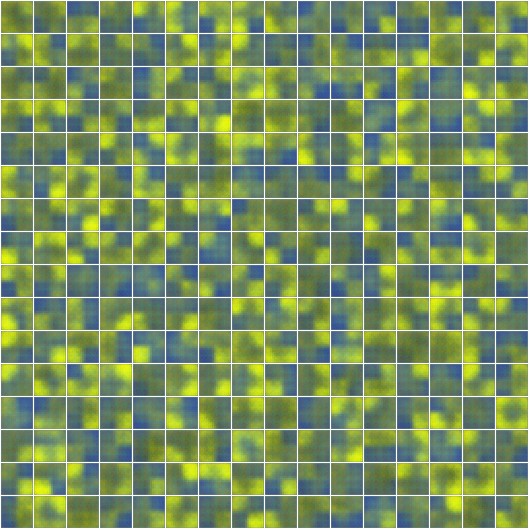

Starting 8


[9/16] - ptime: 119.07, loss_d: 0.05268535, loss_g: 0.07930516


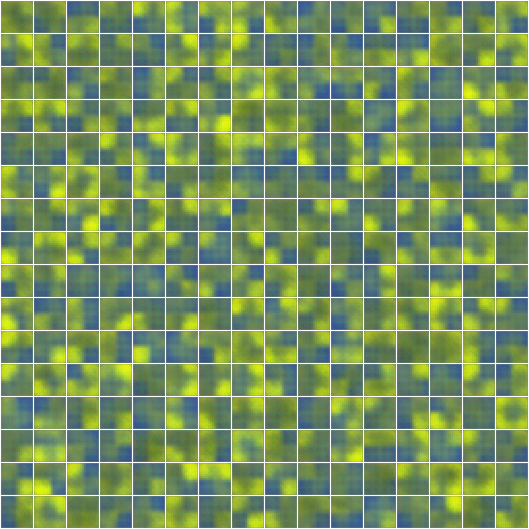

Starting 9
learning rate change!


[10/16] - ptime: 118.76, loss_d: 0.03199879, loss_g: 0.05649338


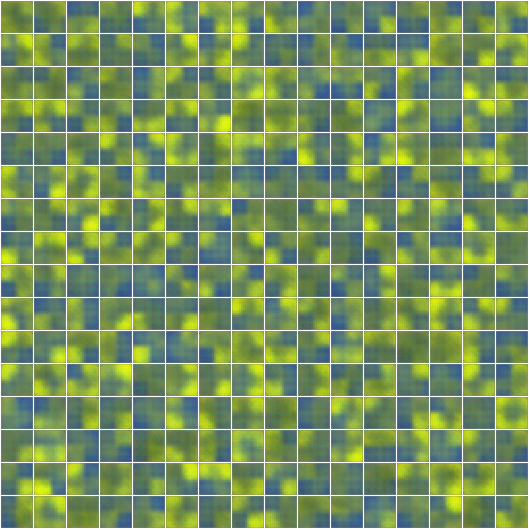

Starting 10


KeyboardInterrupt: 

In [43]:
#training parameters
batch_size = 128
lr = 0.0002
train_epoch = 16
noise = 1.0
vector_size = 256
onehot = True

# network
G = generator(128, vector_size=vector_size)
D = discriminator(128, vector_size=vector_size)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()

fixed_z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()
fixed_x  = torch.zeros(batch_size, vector_size+1, 1, 1)
fixed_x2 = torch.zeros(batch_size, vector_size+1, 1, 1)
for i in range(batch_size):
    fixed_x[i, i+1] = 1.0
    fixed_x2[i, i+1+batch_size] = 1.0
fixed_x = fixed_x.cuda()
fixed_x2 = fixed_x2.cuda()


if onehot:
    loss = nn.NLLLoss()
else:
    loss = nn.MSELoss()
# tv_loss = TVLoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# results save folder
root = 'binary_results/'
model = 'binary_model_'

if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []


print('training start!')
start_time = time.time()
y_fake = torch.zeros(batch_size).type(torch.LongTensor).cuda()
zero = torch.tensor(0).type(torch.FloatTensor).cuda()

def input_noise(input, noise_mult=1.0):
#     rand = (torch.rand(*input.shape) - 0.5).cuda() * noise_mult
#     input = torch.clamp(input + rand, -1, 1)
    r = 20
    angles = torch.tensor([-r + random.random()*2*r for _ in range(input.shape[0])]).cuda()
    input = kornia.geometry.transform.rotate(input, angles)
    
    d = 8
    x = [[( float(int(random.uniform(-d, d)))), float(int(random.uniform(-d, d)))] for _ in range(input.shape[0]) ]
    t = torch.tensor( x ).cuda()
    input = kornia.geometry.transform.translate(input, t)
    return input

for epoch in range(0, train_epoch):
    print('Starting', epoch)
    D_losses = []
    G_losses = []

    # learning rate decay
    if (epoch+1) in [8, 10, 14]:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    epoch_start_time = time.time()
    
    for i in tqdm_notebook(range(300)):
        x, y = make_data(batch_size, vector_size, onehot=onehot)
  
        # train discriminator D
        D.zero_grad()
        z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()
        G_result = G(z, x)
        D_result = D(input_noise(G_result))
        D_loss = loss(D_result.squeeze(), y)
        
        # Train on noise.
        noise_data = normal.Normal(G_result.mean(), G_result.std()).sample(G_result.shape).cuda()
        D_result = D(input_noise(noise_data)).squeeze()
        D_fake_loss = loss(D_result, y_fake)
        
        total_loss = D_loss + D_fake_loss
        total_loss.backward()
        D_optimizer.step()
        D_losses.append(total_loss.item())
        
        ################################################################################################
        # train generator G
        G.zero_grad()
        x, y = make_data(batch_size, vector_size, onehot=onehot)
        z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda()
    
        # Fake data loss.
        G_result = G(z, x)
        D_result = D(input_noise(G_result)).squeeze()
        tv_loss = (
            torch.sum(torch.abs(G_result[:, :, :, :-1] - G_result[:, :, :, 1:])) + 
            torch.sum(torch.abs(G_result[:, :, :-1, :] - G_result[:, :, 1:, :]))
        )
        G_train_loss = loss(D_result, y) + 1e-6*tv_loss# + 1e-6 * G_result.sum()
        G_train_loss.backward()
        G_optimizer.step()
        G_losses.append(G_train_loss.item())

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f, loss_d: %.8f, loss_g: %.8f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    images_1 = make_images(G, fixed_z, fixed_x)
    images_2 = make_images(G, fixed_z, fixed_x2)
    show_images(torch.cat((images_1, images_2), 0), rows=16, path=fixed_p)
    
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
print("Training finish!... save training results")
torch.save(G.state_dict(), root + model + 'generator_param.pkl')
torch.save(D.state_dict(), root + model + 'discriminator_param.pkl')

with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))

imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

In [ ]:
images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))

imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)
with open(root + model + 'generation_animation.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

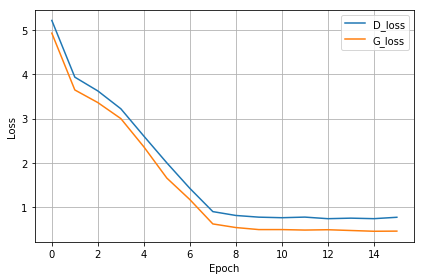

In [340]:
show_train_hist(train_hist, show=True, path=root + model + 'train_hist.png')